In [2]:
import pandas as pd
import numpy as np
import sspa
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, KFold, StratifiedKFold
from mbpls.mbpls import MBPLS
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score, explained_variance_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import RFE, RFECV

# COVID19 case study - metabolomics and proteomics

In [3]:
md = pd.read_csv('../COVID_data/clinical_data.csv')

In [36]:
mo_paths = pd.read_csv("../Pathway_databases/Reactome_multi_omics_ChEBI_Uniprot.csv", index_col=0, dtype='object')

In [5]:
mo_paths_dict = sspa.utils.pathwaydf_to_dict(mo_paths)

In [32]:
prot_uniprot = pd.read_csv('../COVID_data/prot_uniprot.csv', index_col=0, dtype='object')
metab_chebi = pd.read_csv('../COVID_data/metab_chebi.csv', index_col=0, dtype='object')

In [7]:
metab_chebi.index == prot_uniprot.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [8]:
metab_chebi['Group'].value_counts()

Group
Severe    82
Mild      45
Name: count, dtype: int64

In [9]:

def sspa_svd(train, test, pathways, min_entity=2, max_entity=100):

    """
    Kernel PCA method for single sample pathway analysis

    Args:
        mat (pd.DataFrame): pandas DataFrame omics data matrix consisting of m rows (samples) and n columns (entities).
        Do not include metadata columns
        pathways (pd.DataFrame): Dictionary of pathway identifiers (keys) and corresponding list of pathway entities (values).
        Entity identifiers must match those in the matrix columns
        min_entity (int): minimum number of metabolites mapping to pathways for ssPA to be performed

    Returns:
        pandas DataFrame of pathway scores derived using the kPCA method. Columns represent pathways and rows represent samples.
    """

    pathway_matrices_train = []
    pathway_matrices_test = []
    pathway_ids = []
    for pathway, compounds in pathways.items():
        single_pathway_matrix = train.drop(train.columns.difference(compounds), axis=1)
        if min_entity <= single_pathway_matrix.shape[1] <= max_entity:
            pathway_matrices_train.append(single_pathway_matrix.values)
            pathway_matrices_test.append(test.drop(test.columns.difference(compounds), axis=1).values)
            pathway_ids.append(pathway)

    scores_train = []
    scores_test = []
    for n, m in enumerate(pathway_matrices_train):
        kpca = PCA(n_components=2)
        kpca.fit(m)
        scores_train.append(kpca.transform(m)[:, 0])
        scores_test.append(kpca.transform(pathway_matrices_test[n])[:, 0])

        # scatter plot of first two components of kPCA
        # train and test set
        # fig, (ax1, ax2) = plt.subplots(1, 2)
        # sns.scatterplot(x=kpca.transform(pathway_matrices_test[n])[:, 0], y=kpca.transform(pathway_matrices_test[n])[:, 1], ax=ax1, hue=group[test.index])
        # sns.scatterplot(x=kpca.transform(m)[:, 0], y=kpca.transform(m)[:, 1], ax=ax2, hue=group[train.index])
        # plt.show()
    scores_df_train = pd.DataFrame(scores_train, columns=train.index, index=pathway_ids).T
    scores_df_test = pd.DataFrame(scores_test, columns=test.index, index=pathway_ids).T
    return scores_df_train, scores_df_test

In [10]:
concat_omics = pd.concat([metab_chebi.iloc[:, :-1], prot_uniprot.iloc[:, :-1]], axis=1, join='inner')

# Performace

In [11]:
X_train, X_test, y_train, y_test = train_test_split(concat_omics, metab_chebi['Group'], test_size=0.25, random_state=1)

In [12]:
pipe_clf = Pipeline(steps = [('standardscaler', StandardScaler()),
                         ('medianimputer', SimpleImputer(strategy='median')),
                         ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = concat_omics.columns)))],
                      verbose=True)

In [13]:
concat_omics_train = pipe_clf.fit_transform(X_train)
concat_omics_test = pipe_clf.fit_transform(X_test)
concat_omics_all = pipe_clf.fit_transform(concat_omics)


[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.0s
[Pipeline] ..... (step 2 of 3) Processing medianimputer, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing pandarizer, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.0s
[Pipeline] ..... (step 2 of 3) Processing medianimputer, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing pandarizer, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.0s
[Pipeline] ..... (step 2 of 3) Processing medianimputer, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing pandarizer, total=   0.0s


In [14]:
sspa_train, sspa_test = sspa_svd(concat_omics_train, concat_omics_test, mo_paths_dict, min_entity=2, max_entity=40)

In [15]:
sspa_all, _ = sspa_svd(concat_omics_all, concat_omics_all, mo_paths_dict, min_entity=2, max_entity=40)

In [16]:
sspa_train.head()

,R-HSA-109581,R-HSA-109582,R-HSA-109606,R-HSA-109704,R-HSA-110362,R-HSA-110373,R-HSA-111465,R-HSA-112314,R-HSA-112315,R-HSA-112316,...,R-HSA-975871,R-HSA-9758881,R-HSA-9759194,R-HSA-9772572,R-HSA-9772573,R-HSA-983168,R-HSA-983169,R-HSA-983231,R-HSA-983695,R-HSA-983705
0,2.299720,1.882152,-1.952522,0.029318,-0.106153,-0.106153,1.925826,-1.095900,-1.414806,-1.414806,...,2.077104,0.275628,0.482039,-0.267751,1.240375,-0.092230,0.642852,0.727676,0.283719,0.044276
1,-2.396155,-3.261111,1.210289,-0.553094,-0.043528,-0.043528,-1.937421,2.068505,1.950065,1.950065,...,-1.820127,1.319430,-1.116958,-0.499815,-2.113831,-0.573885,-0.491759,-1.524133,-1.305106,-1.264649
2,3.359409,3.436508,-1.321729,1.378050,-0.455461,-0.455461,2.134377,-1.512256,-1.505326,-1.505326,...,1.983954,1.508486,1.874658,0.214807,0.870133,1.585552,1.748472,1.412235,0.801655,1.303080
3,-1.952658,-3.510103,1.427976,-0.168334,0.805784,0.805784,-1.657442,0.762187,1.061167,1.061167,...,-1.613639,-0.341553,-0.083857,0.406229,-0.113750,-1.654599,-1.459718,-1.509765,0.216398,-0.536473
4,-0.104093,-0.181461,0.022247,-2.370010,1.616254,1.616254,0.123545,-0.237350,0.548175,0.548175,...,0.515871,1.254437,-0.339978,2.019371,0.151939,-1.421552,-1.736858,-0.753870,1.695898,1.278879


In [13]:
sspa_train.shape

(95, 369)

In [17]:
rf_tuned = RandomForestClassifier(n_estimators=200,
 min_samples_split=2,
 min_samples_leaf=4,
 max_features='sqrt',
 max_depth=10,
 bootstrap=True,
 oob_score=True)

In [18]:
rf_tuned.fit(sspa_train, pd.factorize(y_train)[0])
y_pred = rf_tuned.predict(sspa_test)

print("ROC:", roc_auc_score(pd.factorize(y_test)[0], y_pred))


ROC: 0.9318181818181819


In [19]:
rf_tuned.oob_score_


0.9263157894736842

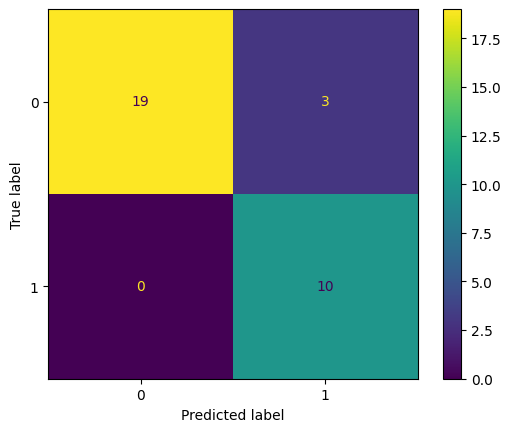

In [20]:
confusion_matrix(pd.factorize(y_test)[0], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(pd.factorize(y_test)[0], y_pred))
disp.plot()
plt.show()

# Feature importance

Apply recursive feature elimination


In [265]:
selector = RFECV(rf_tuned, step=20, cv=5, n_jobs=-1, verbose=1, scoring="f1")
selector = selector.fit(sspa_all, pd.factorize(metab_chebi['Group'])[0])

Fitting estimator with 719 features.
Fitting estimator with 699 features.
Fitting estimator with 679 features.
Fitting estimator with 659 features.
Fitting estimator with 639 features.
Fitting estimator with 619 features.
Fitting estimator with 599 features.
Fitting estimator with 579 features.
Fitting estimator with 559 features.
Fitting estimator with 539 features.
Fitting estimator with 519 features.
Fitting estimator with 499 features.
Fitting estimator with 479 features.
Fitting estimator with 459 features.
Fitting estimator with 439 features.
Fitting estimator with 419 features.
Fitting estimator with 399 features.
Fitting estimator with 379 features.
Fitting estimator with 359 features.
Fitting estimator with 339 features.
Fitting estimator with 319 features.
Fitting estimator with 299 features.
Fitting estimator with 279 features.
Fitting estimator with 259 features.
Fitting estimator with 239 features.
Fitting estimator with 219 features.
Fitting estimator with 199 features.
F

In [266]:
roc_auc_score(y_test, selector.predict(sspa_test))

1.0

In [267]:
len(selector.cv_results_['mean_test_score'],)

37

<AxesSubplot:>

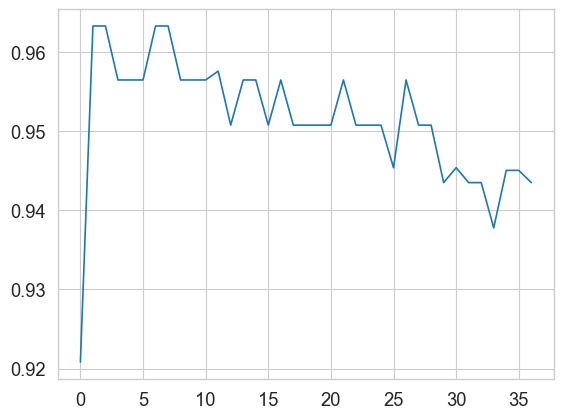

In [268]:
sns.lineplot(y=selector.cv_results_['mean_test_score'], x=range(0, len(selector.cv_results_['mean_test_score'])))

In [269]:
sspa_train.columns[selector.support_]

Index(['R-HSA-140534', 'R-HSA-196854', 'R-HSA-211859', 'R-HSA-2142753',
       'R-HSA-2559582', 'R-HSA-3371378', 'R-HSA-373076', 'R-HSA-380108',
       'R-HSA-500792', 'R-HSA-5218859', 'R-HSA-5218900', 'R-HSA-5621480',
       'R-HSA-5668541', 'R-HSA-6785807', 'R-HSA-6805567', 'R-HSA-6809371',
       'R-HSA-69416', 'R-HSA-75158', 'R-HSA-879415'],
      dtype='object')

In [276]:
selector.estimator_.feature_importances_

array([0.04785956, 0.04304064, 0.06429317, 0.04275665, 0.01759084,
       0.07048844, 0.03568981, 0.03767069, 0.05195289, 0.03191166,
       0.02575243, 0.0775682 , 0.07394658, 0.05120498, 0.11526743,
       0.09455641, 0.04113566, 0.0445326 , 0.03278137])

In [271]:
rfe_df = pd.DataFrame({'Feature':sspa_train.columns[selector.support_], 'Importance':selector.estimator_.feature_importances_})
rfe_df['Name'] = rfe_df['Feature'].apply(lambda x: mo_paths.loc[x, 'Pathway_name'])

In [277]:
rfe_df.sort_values(by='Importance', ascending=False)

,Feature,Importance,Name
14,R-HSA-6805567,0.115267,Keratinization
15,R-HSA-6809371,0.094556,Formation of the cornified envelope
11,R-HSA-5621480,0.077568,Dectin-2 family
12,R-HSA-5668541,0.073947,TNFR2 non-canonical NF-kB pathway
5,R-HSA-3371378,0.070488,Regulation by c-FLIP
2,R-HSA-211859,0.064293,Biological oxidations
8,R-HSA-500792,0.051953,GPCR ligand binding
13,R-HSA-6785807,0.051205,Interleukin-4 and Interleukin-13 signaling
0,R-HSA-140534,0.047860,Caspase activation via Death Receptors in the ...
17,R-HSA-75158,0.044533,TRAIL signaling


In [363]:
rfe_df.shape

(20, 3)

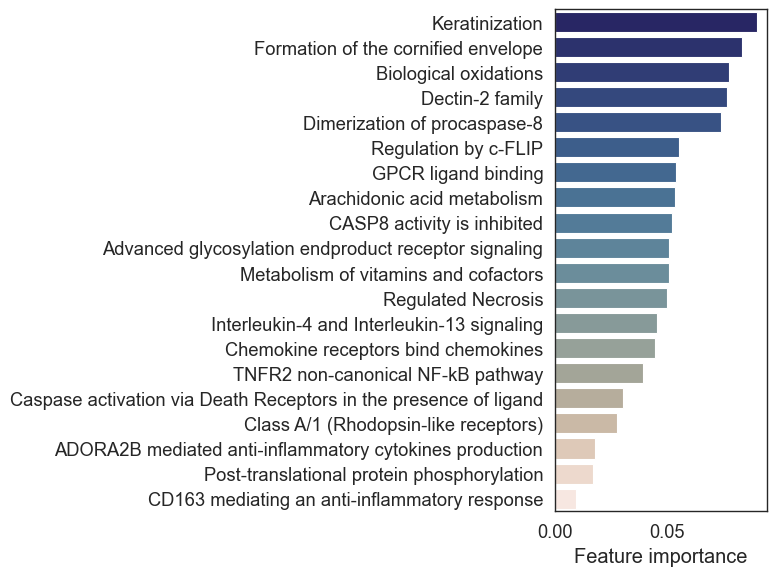

In [362]:
sns.set_context('paper', font_scale=1.5)
sns.set_style('white')
plt.figure(figsize=(8, 6))
sns.barplot(data=rfe_df.sort_values(by='Importance', ascending=False).iloc[0: 30, :], x='Importance', y='Name', palette='cmc.lapaz')
plt.xlabel('Feature importance')
plt.ylabel('')
plt.tight_layout()

In [282]:
selector = RFE(rf_tuned, step=1, verbose=1, n_features_to_select=20)
selector = selector.fit(sspa_all, pd.factorize(metab_chebi['Group'])[0])

Fitting estimator with 719 features.
Fitting estimator with 718 features.
Fitting estimator with 717 features.
Fitting estimator with 716 features.
Fitting estimator with 715 features.
Fitting estimator with 714 features.
Fitting estimator with 713 features.
Fitting estimator with 712 features.
Fitting estimator with 711 features.
Fitting estimator with 710 features.
Fitting estimator with 709 features.
Fitting estimator with 708 features.
Fitting estimator with 707 features.
Fitting estimator with 706 features.
Fitting estimator with 705 features.
Fitting estimator with 704 features.
Fitting estimator with 703 features.
Fitting estimator with 702 features.
Fitting estimator with 701 features.
Fitting estimator with 700 features.
Fitting estimator with 699 features.
Fitting estimator with 698 features.
Fitting estimator with 697 features.
Fitting estimator with 696 features.
Fitting estimator with 695 features.
Fitting estimator with 694 features.
Fitting estimator with 693 features.
F

In [283]:
sspa_test.columns[selector.support_]

Index(['R-HSA-140534', 'R-HSA-196854', 'R-HSA-211859', 'R-HSA-2142753',
       'R-HSA-3371378', 'R-HSA-373076', 'R-HSA-380108', 'R-HSA-500792',
       'R-HSA-5218859', 'R-HSA-5218900', 'R-HSA-5621480', 'R-HSA-5668541',
       'R-HSA-6785807', 'R-HSA-6805567', 'R-HSA-6809371', 'R-HSA-69416',
       'R-HSA-879415', 'R-HSA-8957275', 'R-HSA-9660821', 'R-HSA-9662834'],
      dtype='object')

In [284]:
rfe_df = pd.DataFrame({'Feature':sspa_train.columns[selector.support_], 'Importance':selector.estimator_.feature_importances_})
rfe_df['Name'] = rfe_df['Feature'].apply(lambda x: mo_paths.loc[x, 'Pathway_name'])


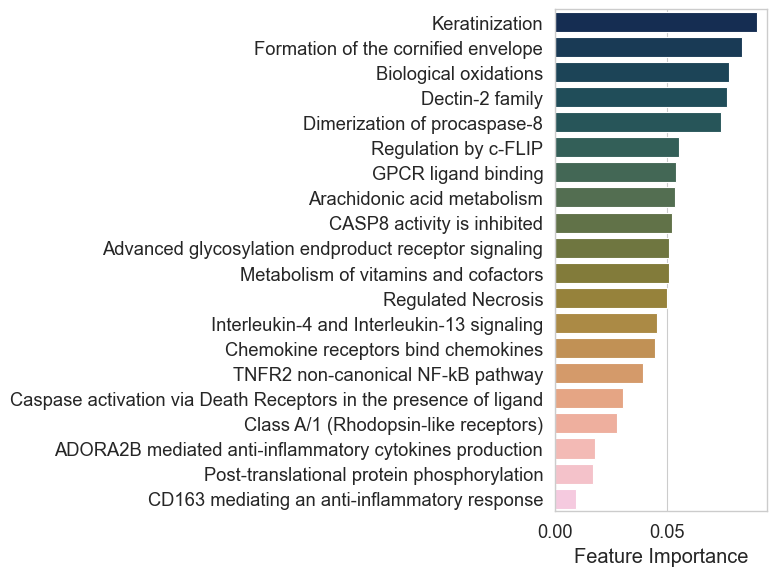

In [285]:
sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(8, 6))
sns.barplot(data=rfe_df.sort_values(by='Importance', ascending=False), x='Importance', y='Name', palette='cmc.batlow')
plt.xlabel('Feature Importance')
plt.ylabel('')
plt.tight_layout()

# How pathway coverage changes

In [37]:
metab_chebi_filt = metab_chebi.loc[:, ~metab_chebi.columns.str.contains("[a-zA-Z]")]
mo_paths_dict = sspa.utils.pathwaydf_to_dict(mo_paths)
compounds_present = [str(i) for i in metab_chebi_filt.columns.tolist()]
print(len(compounds_present))

pathways_present_metab = {k: v for k, v in mo_paths_dict.items() if len([i for i in compounds_present if i in v]) >= 2}
print(len(pathways_present_metab))
path_coverage_metab = {k: len([i for i in v if i in compounds_present]) for k, v in pathways_present_metab.items()}
print(len(path_coverage_metab))

proteins_present = [str(i) for i in prot_uniprot.columns.tolist()]
print(len(proteins_present))

pathways_present_prot = {k: v for k, v in mo_paths_dict.items() if len([i for i in proteins_present if i in v]) >= 2}
print(len(pathways_present_prot))
path_coverage_prot = {k: len([i for i in v if i in proteins_present]) for k, v in pathways_present_prot.items()}
print(len(path_coverage_prot))
concat_omics_filt = pd.concat([metab_chebi_filt, prot_uniprot])
mo_present = [str(i) for i in concat_omics_filt.columns.tolist()]
print(len(mo_present))

pathways_present_mo = {k: v for k, v in mo_paths_dict.items() if len([i for i in mo_present if i in v]) >= 2}
print(len(pathways_present_mo))
path_coverage_mo = {k: len([i for i in v if i in mo_present]) for k, v in pathways_present_mo.items()}
print(len(path_coverage_mo))
print(np.mean(list(path_coverage_metab.values())))
print(np.mean(list(path_coverage_prot.values())))
print(np.mean(list(path_coverage_mo.values())))
coverage_stats = pd.concat(
    [
        pd.DataFrame(path_coverage_metab.values(), columns=['Metabolomics']).T, 
        pd.DataFrame(path_coverage_prot.values(), columns=['Proteomics']).T, 
        pd.DataFrame(path_coverage_mo.values(), columns=['Multi-omics']).T
    ]
)
coverage_stats_melt = coverage_stats.T.melt(var_name='Omics')
pd.DataFrame({
        'Metabolomics':len(path_coverage_metab),
        'Proteomics':len(path_coverage_prot),
        'Multi-omics':len(path_coverage_mo)
    },
    index=['a'])


314
169
169
456
599
599
770
739
739
4.78698224852071
6.215358931552587
6.359945872801083


,Metabolomics,Proteomics,Multi-omics
a,169,599,739


C:\Users\cw2019\AppData\Local\Temp\ipykernel_18296\3707918273.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels=['Metabolomics', 'Proteomics', 'Multi-omics'], rotation=45)


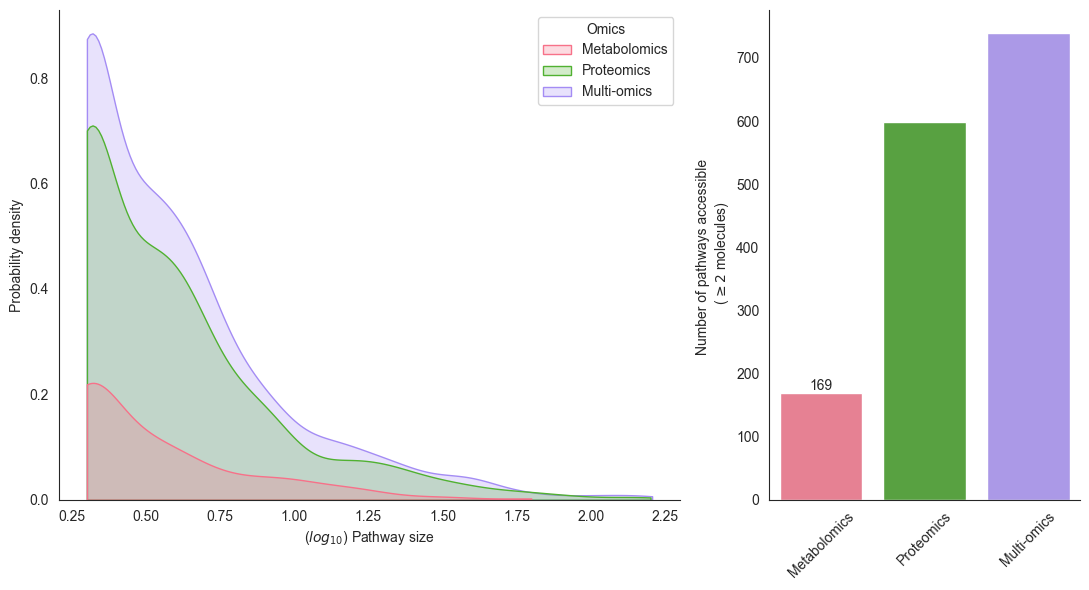

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6),gridspec_kw={'width_ratios': [2, 1]})
sns.set_style('white')
sns.kdeplot(
    data=coverage_stats_melt,
    # x='variable',
    x=np.log10(coverage_stats_melt['value']),
    hue='Omics',
    fill='true',
    palette=[sns.color_palette('husl', 3)[0], sns.color_palette('husl', 3)[1], sns.color_palette('husl', 4)[3]],
    cut=0,
    ax=ax1
)
sns.despine()
sns.barplot(
    data=pd.DataFrame({
        'Metabolomics':len(path_coverage_metab),
        'Proteomics':len(path_coverage_prot),
        'Multi-omics':len(path_coverage_mo)
    },
    index=['Pathways accessible']),
    palette=[sns.color_palette('husl', 3)[0], sns.color_palette('husl', 3)[1], sns.color_palette('husl', 4)[3]],
    ax=ax2
)
ax2.bar_label(ax2.containers[0])
ax1.set_xlabel('($log_{10}$) Pathway size')
ax1.set_ylabel('Probability density')
ax2.set_ylabel('Number of pathways accessible \n ($\geq 2$ molecules)')
ax2.set_xticklabels(labels=['Metabolomics', 'Proteomics', 'Multi-omics'], rotation=45)
plt.tight_layout()
# plt.savefig('../Figures/COVID_pathway_coverage_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Importace of molecules in pathway

In [39]:
def get_molecule_importances_bootstrap(mat, query_mols, query_id, min_entity=2, nboot=50):

    """
    Tomfohr et al 2004 SVD/PLAGE method for single sample pathway analysis

    Args:
        mat (pd.DataFrame): pandas DataFrame omics data matrix consisting of m rows (samples) and n columns (entities).
        Do not include metadata columns
        pathways (pd.DataFrame): Dictionary of pathway identifiers (keys) and corresponding list of pathway entities (values).
        Entity identifiers must match those in the matrix columns
        min_entity (int): minimum number of metabolites mapping to pathways for ssPA to be performed

    Returns:
        pandas DataFrame of pathway scores derived using the PLAGE method. Columns represent pathways and rows represent samples.
    """
    loadings_all = []
    for i in range(0, nboot):
        pathway_matrices = []
        pathway_ids = []

        mat_samp = mat.sample(500, replace=True)

        single_pathway_matrix = mat_samp.drop(mat_samp.columns.difference(query_mols), axis=1)

        pca = PCA(n_components=1, random_state=1)
        new_data = pca.fit_transform(single_pathway_matrix)
        loadings = pca.components_[0]
        loadings_all.append(loadings)

    return pd.DataFrame(loadings_all, columns=single_pathway_matrix.columns)


In [40]:
covid_imp_bs = get_molecule_importances_bootstrap(concat_omics_all,
                                                  list(mo_paths_dict['R-HSA-9660821']),
                                                  'R-HSA-9660821', nboot=200)


In [41]:
covid_imp_bs

,28834,16335,P05231,P35318,Q03431,P01222,P01229,P01258,P06850
0,0.005446,-0.150157,0.577174,0.460747,-0.189736,-0.141327,-0.141835,0.526344,-0.280849
1,-0.022437,-0.161202,0.575464,0.487457,-0.126080,-0.198754,-0.049310,0.507791,-0.298420
2,-0.029531,-0.153591,0.536309,0.527443,-0.148073,-0.108237,-0.009119,0.558166,-0.253853
3,-0.027898,-0.162851,0.560281,0.469425,-0.141315,-0.171717,-0.044690,0.559983,-0.270910
4,-0.017663,-0.107624,0.601452,0.505526,-0.117309,-0.140995,-0.149995,0.476695,-0.295680
...,...,...,...,...,...,...,...,...,...
195,-0.021124,-0.099294,0.553285,0.488192,-0.144978,-0.124792,-0.100737,0.556599,-0.297821
196,-0.056628,-0.146535,0.543901,0.512964,-0.185579,-0.129428,-0.045728,0.531370,-0.284120
197,-0.032112,-0.195453,0.527076,0.537524,-0.113712,-0.163118,0.011305,0.506516,-0.312732
198,-0.039477,-0.196674,0.563051,0.489945,-0.145977,-0.141924,-0.033791,0.530759,-0.279980


In [42]:
covid_imp_bs.mean(axis=0).index

Index(['28834', '16335', 'P05231', 'P35318', 'Q03431', 'P01222', 'P01229',
       'P01258', 'P06850'],
      dtype='object')

In [43]:
covid_imp_bs = covid_imp_bs.rename(columns={'28834': 'Deoxycholic acid',
                                    '16335': 'Adenosine',
                                    'P05231': 'Interleukin-6', 
                                    'P35318': 'Pro-adrenomedullin', 
                                    'Q03431': 'Parathyroid hormone receptor', 
                                    'P01222': 'Thyrotropin subunit beta', 
                                    'P01229': 'Lutropin subunit beta',
                                    'P01258': 'Calcitonin', 
                                    'P06850': 'Corticoliberin',
                                    })


In [44]:
covid_imp_bs.melt()

,variable,value
0,Deoxycholic acid,0.005446
1,Deoxycholic acid,-0.022437
2,Deoxycholic acid,-0.029531
3,Deoxycholic acid,-0.027898
4,Deoxycholic acid,-0.017663
...,...,...
1795,Corticoliberin,-0.297821
1796,Corticoliberin,-0.284120
1797,Corticoliberin,-0.312732
1798,Corticoliberin,-0.279980


In [45]:
covid_imp_bs.mean(axis=0)

Deoxycholic acid               -0.049647
Adenosine                      -0.159431
Interleukin-6                   0.544054
Pro-adrenomedullin              0.497027
Parathyroid hormone receptor   -0.143048
Thyrotropin subunit beta       -0.127593
Lutropin subunit beta          -0.049244
Calcitonin                      0.527581
Corticoliberin                 -0.279824
dtype: float64

C:\Users\cw2019\AppData\Local\Temp\ipykernel_18296\1373710681.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.pointplot(
C:\Users\cw2019\AppData\Local\Temp\ipykernel_18296\1373710681.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.pointplot(
C:\Users\cw2019\AppData\Local\Temp\ipykernel_18296\1373710681.py:5: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.pointplot(
C:\Users\cw2019\AppData\Local\Temp\ipykernel_18296\1373710681.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 5}` instead.

  g = sns.pointplot(


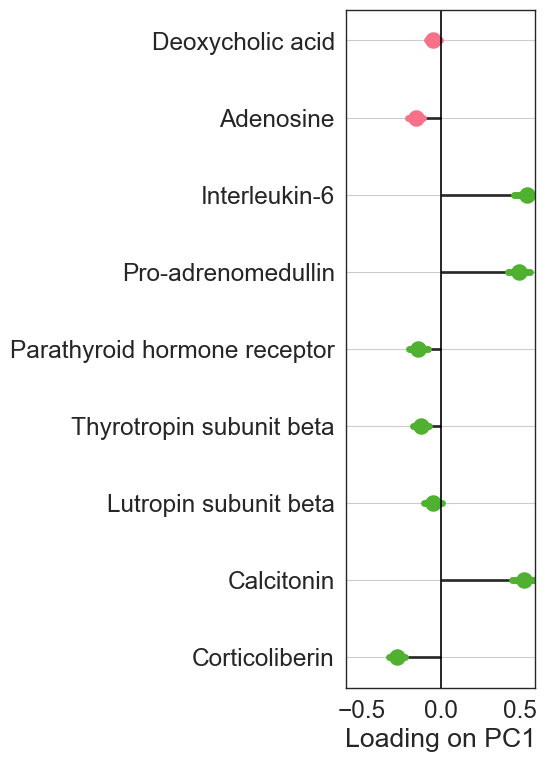

In [46]:
import matplotlib.patches as mpatches
sns.set_context('paper', font_scale=2)
sns.set_style('white')
plt.figure(figsize=(6, 8))
g = sns.pointplot(
    data=covid_imp_bs.melt(),
    y='variable',
    x='value',
    orient='h',
    palette=2*[sns.color_palette('husl', 3)[0]] + 7*[sns.color_palette('husl', 3)[1]],
    ci='sd',
    errwidth=5,
    scale = 2
)

plt.hlines(y=covid_imp_bs.mean(axis=0).index, xmin=0, xmax=covid_imp_bs.mean(axis=0), color='k',
           linewidth=2, alpha =0.8, zorder=1)
plt.axvline(0, color='k')
g.set_xlim(-0.6, 0.6)
g.set(ylabel='', xlabel='Loading on PC1')

g.xaxis.grid(False)
g.yaxis.grid(True)
red_patch = mpatches.Patch(color=sns.color_palette('husl', 3)[1], label='Proteomics')
blue_patch = mpatches.Patch(color=sns.color_palette('husl', 3)[0], label='Metabolomics')
# plt.legend(handles=[blue_patch, red_patch], bbox_to_anchor=(1, 1.1), frameon=False, ncol=2)
# plt.title('Arachidonic acid metabolism')
plt.tight_layout()
# plt.savefig('../Figures/M0_ADORA2B_molecule_importance.png', dpi=300)
plt.show()